# 1. Rectified flow

In [1]:
import torch
from torch import nn, Tensor
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from tqdm import tqdm

# Set device to MPS if available, otherwise fallback to CPU
device = torch.device("cpu")
print(f"Using device: {device}")


def midpoint_ode_solver(x_t: Tensor, t_start: Tensor, t_end: Tensor, v_t) -> Tensor:
    """Midpoint ODE Solver"""
    return x_t + (t_end - t_start) * v_t(
        x_t + v_t(x_t, t_start) * (t_end - t_start) / 2,
        t_start + (t_end - t_start) / 2
    )


class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim)
        )

    def forward(self, x_t: Tensor, t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))

    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        return midpoint_ode_solver(x_t, t_start, t_end, self.forward)


# Instantiate model and move to device
flow = Flow().to(device)
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

Using device: cpu


# Before training

In [2]:
def plot_traj(x_traj, direction='Backward', color='b'):
    x_traj = x_traj.permute(1, 0, 2)
    x = x_traj[0]
    n_steps = len(x_traj)-1
    time_steps = torch.linspace(0, 1.0, n_steps + 1)

    fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
    axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10, color=color)
    axes[0].set_title(f't = {time_steps[0]:.2f}', fontsize=25)
    axes[0].set_xlim(-3.0, 3.0)
    axes[0].set_ylim(-3.0, 3.0)
    axes[0].set_ylabel(direction, fontsize=25)
    
    for i in range(n_steps):
        x = x_traj[i+1]
        axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10, color=color)
        axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}', fontsize=25)
    
    plt.tight_layout()
    plt.show()
    


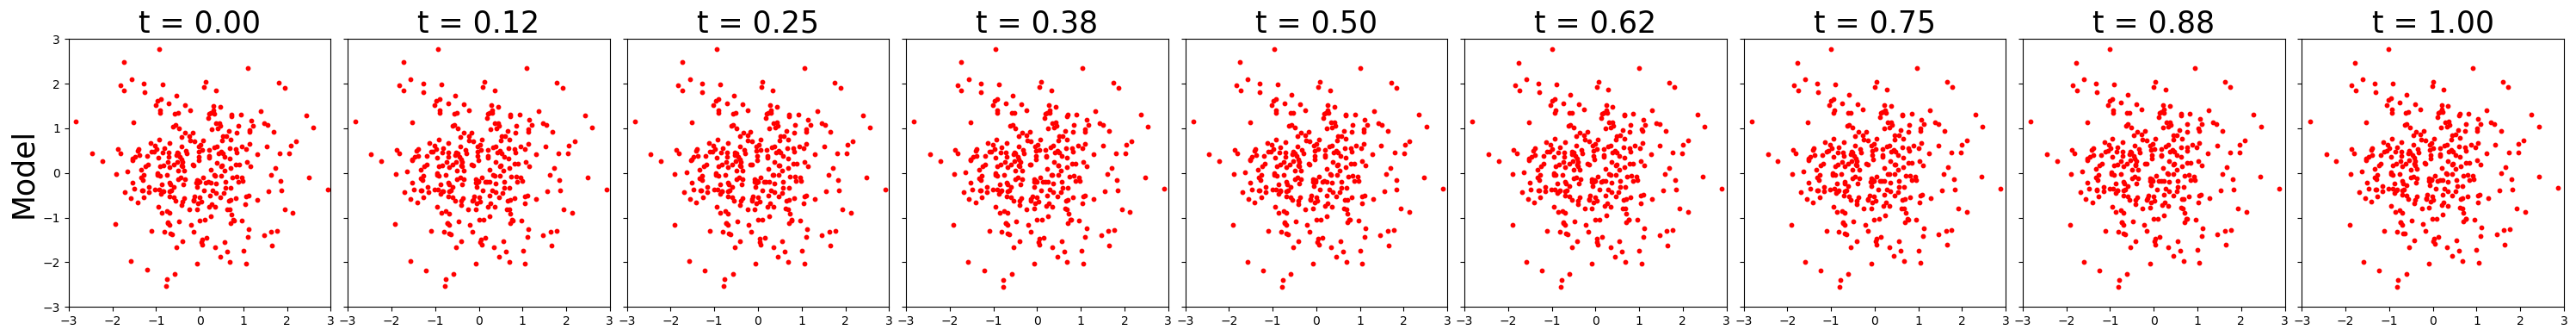

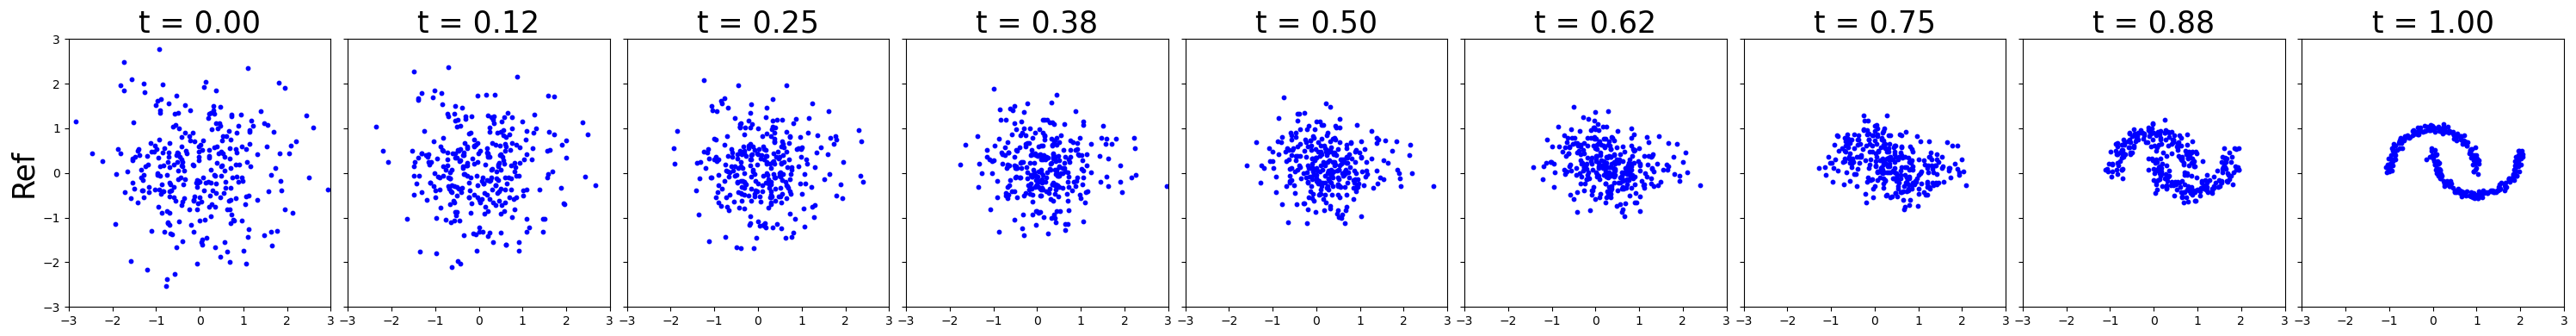

In [3]:
def sampling_trajs(n_steps = 8, flow=flow, device=device):
    # sampling
    x_model, x_ref = [], []
    x_0 = torch.randn(300, 2).to(device)
    x_1 = Tensor(make_moons(300, noise=0.05)[0]).to(device)
    dx_t = x_1 - x_0

    x_ref.append(x_0)
    x_model.append(x_0)

    
    time_steps = torch.linspace(0, 1.0, n_steps + 1).to(device)

    x_model_t = x_0
    x_ref_t = x_0

    def ref_vt(x_t, input1=None, input2=None):
        return x_1 - x_0
    
    
    for i in range(n_steps):
        # Reference traj
        x_ref_t = midpoint_ode_solver(x_ref_t, time_steps[i], time_steps[i + 1], ref_vt)
        x_ref.append(x_ref_t)
    
        # Model traj
        x_model_t = flow.step(x_model_t, time_steps[i], time_steps[i + 1])
        x_model.append(x_model_t)

        
    # Output shape [num_samples, time_steps, feature_dim]   
    return torch.stack(x_model, 1), torch.stack(x_ref, 1)

x_model, x_ref = sampling_trajs(n_steps = 8, flow=flow, device=device)

plot_traj(x_model.cpu().detach(), 'Model', 'r')
plot_traj(x_ref.cpu(), 'Ref')


In [4]:
# Training
for _ in tqdm(range(10000)):
    x_1 = Tensor(make_moons(256, noise=0.05)[0]).to(device)
    x_0 = torch.randn_like(x_1).to(device)
    t = torch.rand(len(x_1), 1).to(device)
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    optimizer.zero_grad()
    loss_fn(flow(x_t, t), dx_t).backward()
    optimizer.step()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:08<00:00, 146.21it/s]


# After training

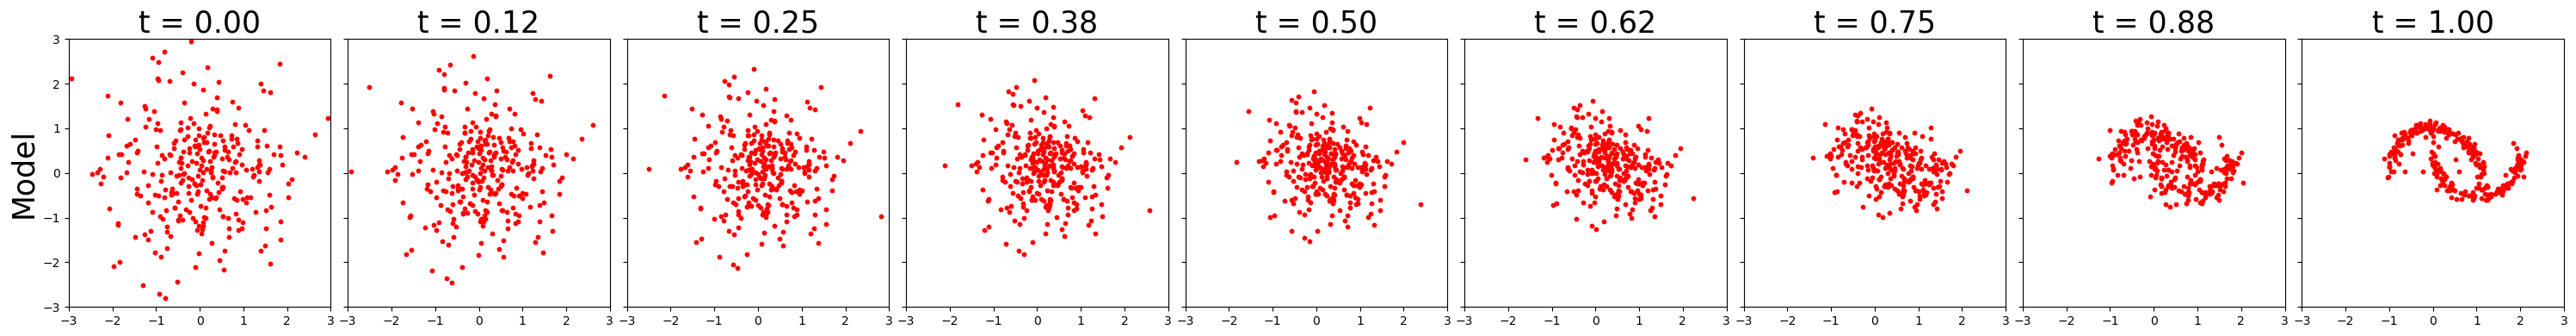

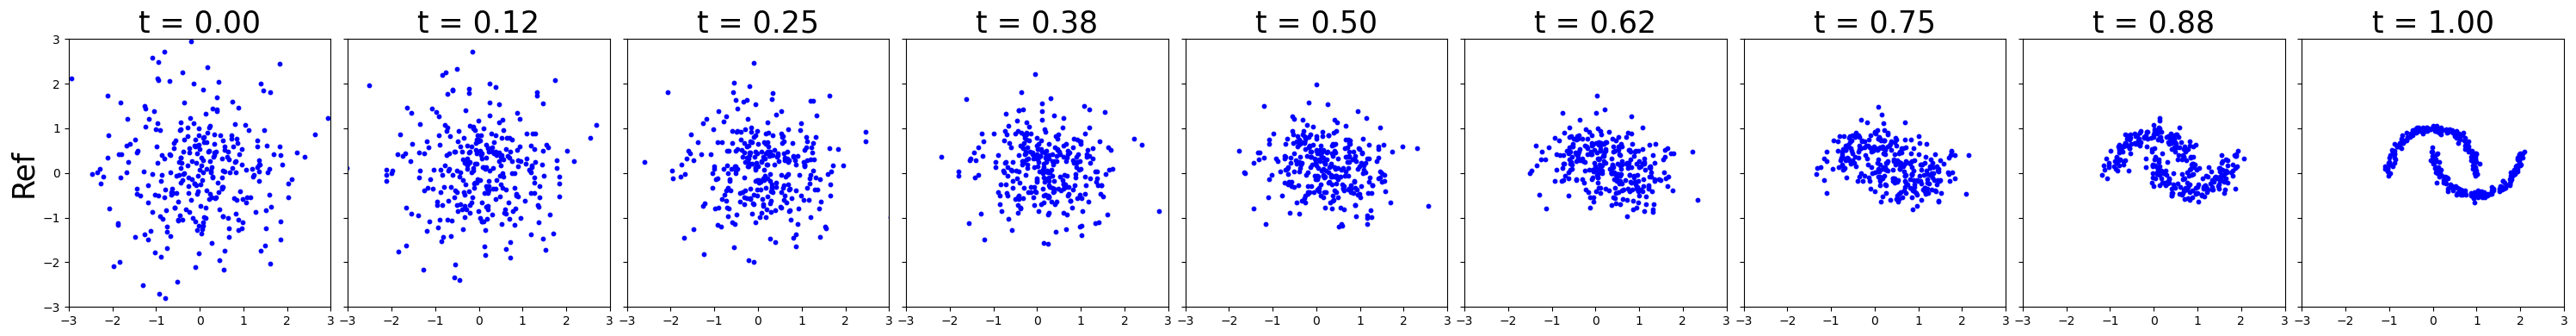

In [5]:
x_model, x_ref = sampling_trajs(n_steps = 8, flow=flow)

plot_traj(x_model.cpu().detach(), 'Model', 'r')
plot_traj(x_ref.cpu(), 'Ref')
    

# 2. Using PCF

In [6]:
from src.PCF_with_empirical_measure import PCF_with_empirical_measure


pcf = PCF_with_empirical_measure(16, 10, 2, add_time=True).to(device)

# Instantiate model and move to device
flow = Flow().to(device)
G_opt = torch.optim.Adam(flow.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

D_opt = torch.optim.Adam(pcf.parameters(), lr=1e-4)

In [8]:
# Training
for _ in tqdm(range(1000)):
    
    # Train the discriminator
    pcf.train()
    x_model, x_ref = sampling_trajs(n_steps=8, flow=flow, device=device)

    D_loss = -pcf.distance_measure(x_model, x_ref, Lambda=1.0)
    D_opt.zero_grad()
    D_loss.backward()
    D_opt.step()
    
        
    pcf.eval()
    x_model, x_ref = sampling_trajs(n_steps=8, flow=flow)
    G_loss =  pcf.distance_measure(x_model, x_ref, Lambda=1.0)

    G_opt.zero_grad()
    G_loss.backward()
    G_opt.step()
    print(D_loss, G_loss)
    break

  0%|                                                                                                                                        | 0/1000 [00:12<?, ?it/s]

tensor(-0.9532, grad_fn=<NegBackward0>) tensor(0.9825, grad_fn=<AddBackward0>)
